# Computing matrix elements with Heller-type Gaussian wavepackets

## Table of Contents (note solutions are added in TOC)<a name="TOC"></a>

1. [General setups](#setups)
2. [Plotting the Gaussian wavepackets with `gwp_value` function](#plotting_gwp)

  2.1. [1D Gaussian wavepacket](#1d_plotting) | [Exercise1](#exercise1) | [Solution1](#solution1)
  
  2.2. [2D Gaussian wavepacket](#2d_plotting)
   
3. [Computing overlaps of Gaussian wavepackets with `gwp_overlap` function](#gwp_overlap)

  3.1. [Same-alpha version](#gwp_overlap-same-alpha) | [Exercise2](#exercise2) | [Solution2](#solution2) | [Exercise3](#exercise3) | [Solution3](#solution3)
  
  3.2. [1D general](#gwp_overlap-one-d-general) | [Exercise4](#exercise4) | [Solution4](#solution4)
  
  3.3. [N-D general](#gwp_overlap-many-d-general) | [Exercise5](#exercise5) | [Solution5](#solution5) | [Exercise6](#exercise6) | [Solution6](#solution6) 

4. [Computing transition dipole moment with `gwp_dipole` function](#gwp_dipole)

  4.1. [Same-alpha version](#gwp_dipole-same-alpha)
  
  4.2. [1D general](#gwp_dipole-one-d-general) | [Exercise7](#exercise7)
  
  4.3. [N-D general](#gwp_dipole-many-d-general) 
  
5. [Computing derivative coupling matrix elements with `gwp_coupling` function](#gwp_coupling)

  5.1. [Same-alpha version](#gwp_coupling-same-alpha)
  
  5.2. [General](#gwp_coupling-general) | [Exercise8](#exercise8) | [Exercise9](#exercise9)

6. [Computing the kinetic energy matrix elements with `gwp_kinetic` function](#gwp_kinetic)

  6.1. [Same-alpha version](#gwp_kinetic-same-alpha)
  
  6.2. [General](#gwp_kinetic-general) | [Exercise10](#exercise10)


## A. Learning objectives

- to compute various types of matrix elements involving Gaussian wavepackets
- to visualize 1D and 2D properties of Gaussian wavepackets
- to predict how computed properties depend on parameters of the Gaussian wavepacket
- to be able to tell the difference between quantum and classical kinetic energies of a Gaussian wavepacket
- to argument the conceptual flaw of considering classical particles as a zero-width limit of Gaussian wavepackets

## B. Use cases

- [Plotting 1D wavepackets](#1d_plotting)
- [Plotting 2D wavepackets](#2d_plotting)
- [Computing overlaps of Heller's wavepeckets](#gwp_overlap)
- [Computing transition dipole matrix elements with Heller's wavepeckets](#gwp_dipole)
- [Computing derivative coupling matrix elements with Heller's wavepeckets](#gwp_coupling)
- [Computing kinetic energy operator matrix elements with Heller's wavepeckets](#gwp_kinetic)


## C. Functions

- `liblibra::libdyn::libgwp`
  - [`gwp_coupling`](#gwp_coupling_function)    
  - [`gwp_dipole`](#gwp_dipole_function)
  - [`gwp_kinetic`](#gwp_kinetic_function)
  - [`gwp_overlap`](#gwp_overlap_function)
  - [`gwp_value`](#gwp_value)
    
- `libra_py`
  - `data_visualize`
   - [`plot_map`](#plot_map)      

## D. Classes and class members
    
    None

## 1. General setups
<a name="setups"></a>[Back to TOC](#TOC)

First, lets import all the necessary libraries and define all the variables that we may need

In [1]:
import os
import math
import sys
import numpy as np

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import *

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

Also, lets import matplotlib for plotting and define all the plotting parameters: sizes, colors, etc.

In [2]:
import matplotlib.pyplot as plt   # plots
from scipy.interpolate import griddata

%matplotlib inline 


plt.rc('axes', titlesize=38)      # fontsize of the axes title
plt.rc('axes', labelsize=38)      # fontsize of the x and y labels
plt.rc('legend', fontsize=38)     # legend fontsize
plt.rc('xtick', labelsize=38)    # fontsize of the tick labels
plt.rc('ytick', labelsize=38)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

## 2. Plotting the Gaussian wavepackets with `gwp_value` function
<a name="gwp_value"></a><a name="plotting_gwp"></a>[Back to TOC](#TOC)


This function computes the value of a multidimensional Gaussian at a given point r

$
G_a(r; R_a, P_a, \alpha_a, \gamma_a) = (\frac{2 \alpha_a}{\pi})^{\frac{Ndof}{4}} exp[-\alpha_a (r-R_a)^2 + \frac{i P_a}{\hbar} (r-R_a) + \frac{i \gamma_a}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_value(MATRIX& r, MATRIX& R, MATRIX& P, double gamma,  double alp, double hbar)
       
The parameters are as follows:

  * `R` (MATRIX(Ndof x 1)) - multidimensional coordinate of the center of the Gaussian. 
  * `P` (MATRIX(Ndof x 1)) - multidimensional momentum (classical) of the center of the Gaussian. 
  * `gamma` (double) - phase of the overall Gaussian
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for all components of the multidimensional Gaussians
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the Gaussian function - a complex number
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)

### 2.1. 1D model
<a name="gwp_value"></a><a name="1d_plotting"></a>[Back to TOC](#TOC)

Lets setup a 1D grid and compute the wavepacket amplitudes at all grid points

In [3]:
# original hbar = 1.0, alpha = 1.0, gamma = 0.5
hbar = 1.0
alpha = 1.0
gamma = 0.5
P = MATRIX(1,1); P.set(0, 0, 1.0)
R = MATRIX(1,1); R.set(0, 0, -1.0)
r = MATRIX(1,1);

x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
g_re, g_im = [], []
for x in x_grid:
    r.set(0, 0, x)
    g_val = gwp_value(r, R, P, gamma, alpha, hbar)
    g_re.append( g_val.real )
    g_im.append( g_val.imag )

Plot the results

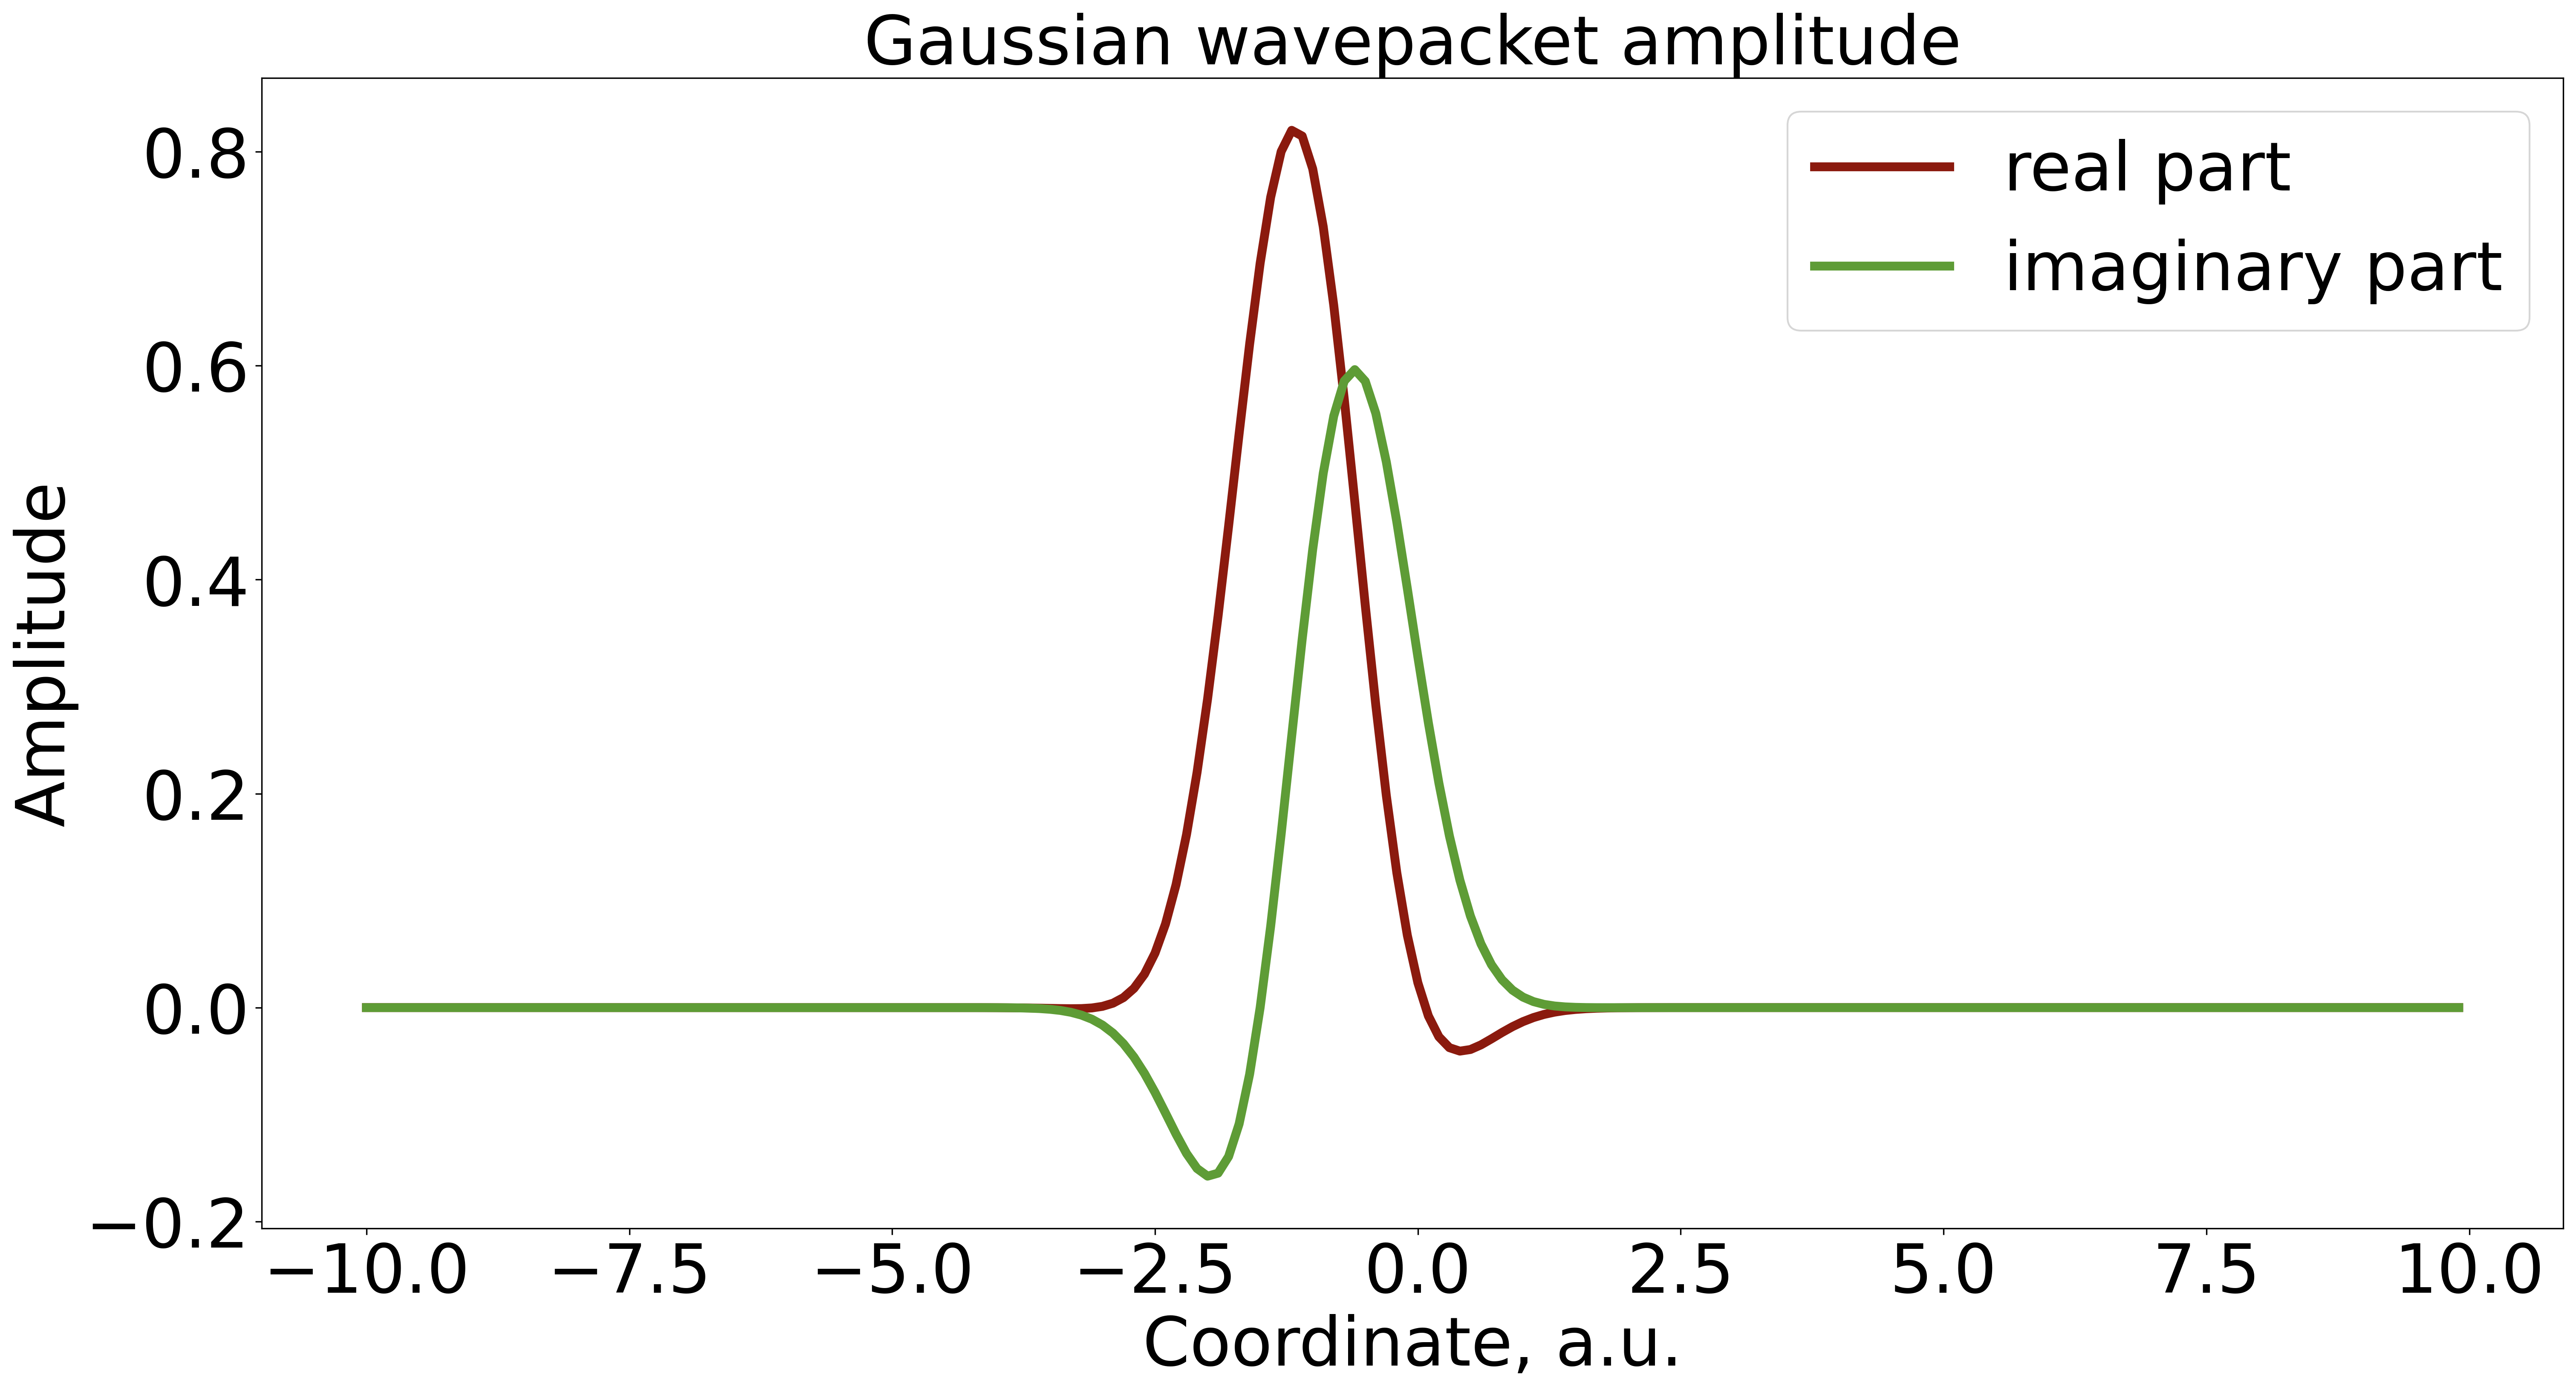

In [4]:
plt.figure(1, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Gaussian wavepacket amplitude')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Amplitude')

plt.plot(x_grid, g_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, g_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### Exercise 1
<a name="exercise1"></a>[Back to TOC](#TOC)

Play around with the parameters of the wavepacket:
* $\alpha$ (`alp`) 
* $\gamma$ (`gamma`) 
* $R$ (`R`)
* $P$ (`P`)

What property of the GWP does each parameter define?

### Solution 1
<a name="solution1"></a>[Back to TOC](#TOC) 
                  
We can use mathematical relationships and "playing around" to determine that:
* $\alpha$ - relates to the peak width
* $\gamma$ - relates to the phase of the waves
* $R_a$ - average position
* $P_a$ - average momenta

### 2.2. 2D model
<a name="gwp_value"></a><a name="2d_plotting"></a>[Back to TOC](#TOC)

Lets setup a 2D grid and compute the wavepacket amplitudes at all grid points

In [5]:
hbar = 1.0
alpha = 1.0
gamma = 0.5
P = MATRIX(2,1); P.set(0, 0, 1.0);  P.set(1, 0, 0.0)
R = MATRIX(2,1); R.set(0, 0, -1.0); R.set(1, 0, 0.0)
r = MATRIX(2,1);

x_grid, y_grid = [], []
for i in range(50):
    x_grid.append(-5.0 + 0.2*i)
    y_grid.append(-5.0 + 0.2*i)
    
g_re, g_im = [], []
for x in x_grid:
    g_re_x, g_im_x = [], []
    for y in y_grid:
        
        r.set(0, 0, x)
        r.set(1, 0, y)
    
        g_val = gwp_value(r, R, P, gamma, alpha, hbar)
        g_re_x.append( g_val.real )
        g_im_x.append( g_val.imag )
        
    g_re.append(g_re_x)
    g_im.append(g_im_x)

Plot the results
<a name="plot_map"></a>

No handles with labels found to put in legend.


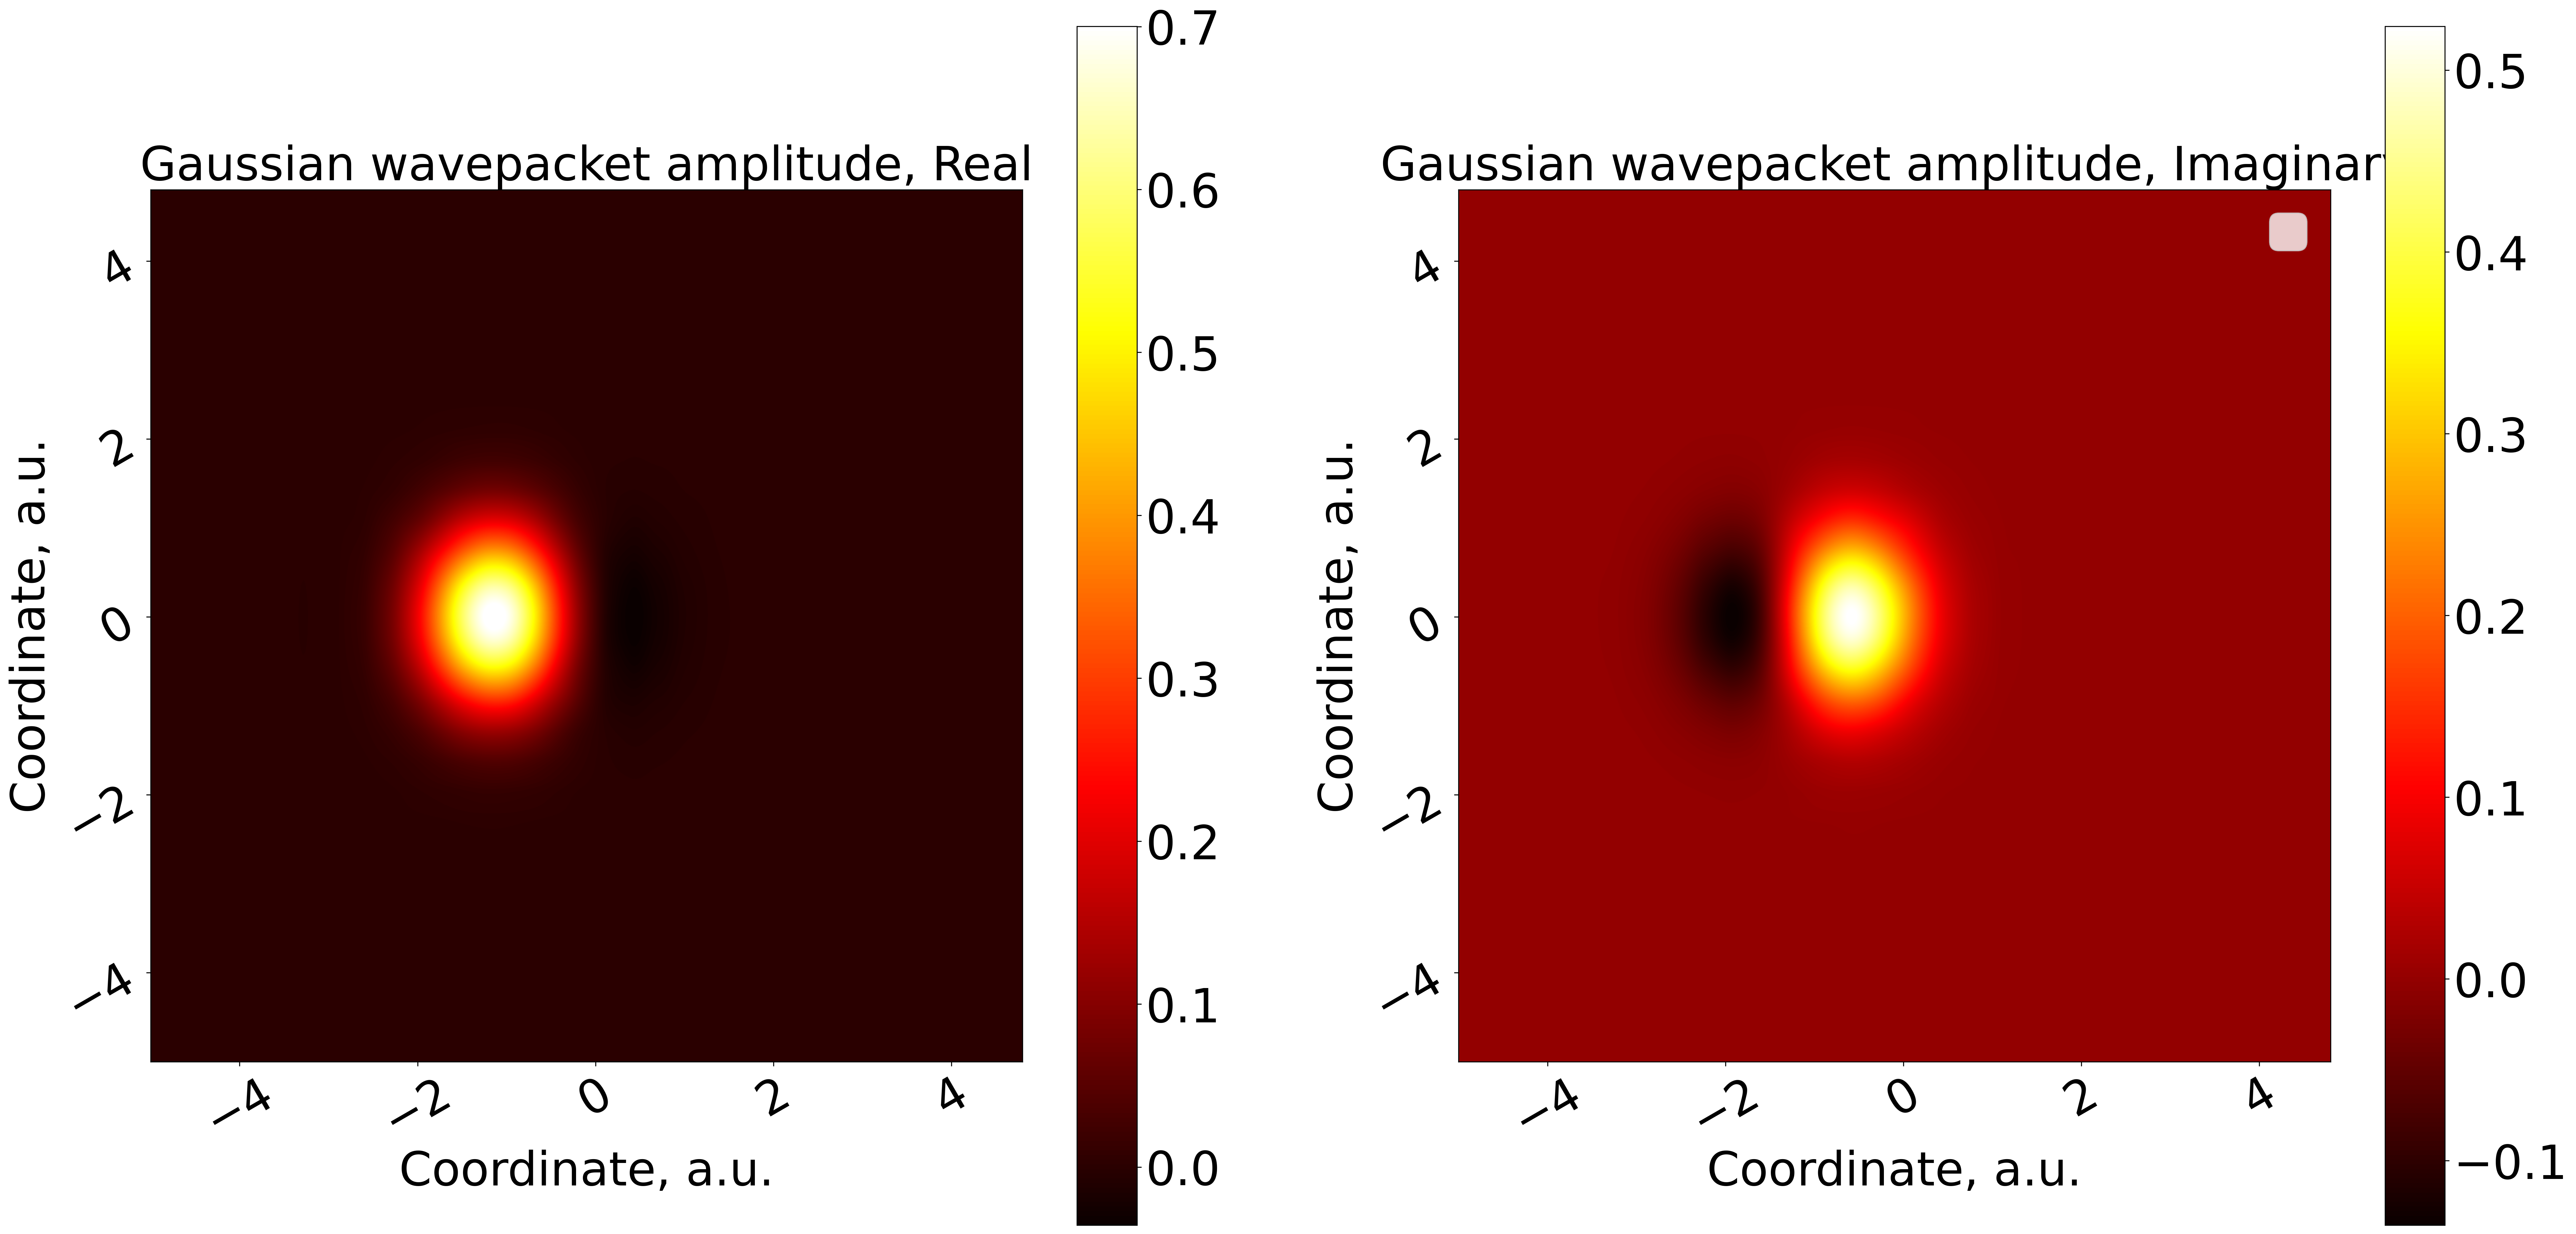

In [6]:
plt.figure(1, figsize=(36, 18), dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Gaussian wavepacket amplitude, Real')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_re, "hot", 30j )

plt.subplot(1,2,2)
plt.title('Gaussian wavepacket amplitude, Imaginary')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_im, "hot", 30j )

plt.legend()
plt.show()
plt.close()

## 3. Computing overlaps of Gaussian wavepackets with `gwp_overlap` function
<a name="gwp_overlap"></a>[Back to TOC](#TOC)


### 3.1. The version with same alpha

<a name="gwp_overlap-same-alpha"></a>[Back to TOC](#TOC)


This function computes the overlap:

$ < G_1 | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2 = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_overlap(MATRIX& R1, MATRIX& P1, double gamma1, 
                            MATRIX& R2, MATRIX& P2, double gamma2, 
                            double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the overlap of the two Gaussian functions - a complex number
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute overlap between two GWPs as a function of their relative position

<a name="gwp_overlap_function"></a>

In [7]:
# original parameters hbar = 1.0, alpha = 1.0, gamma1 = gamma2 = 0.5
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
ovlp_re, ovlp_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    s_val = gwp_overlap(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar)
    ovlp_re.append( s_val.real )
    ovlp_im.append( s_val.imag )
    

Now plot it:

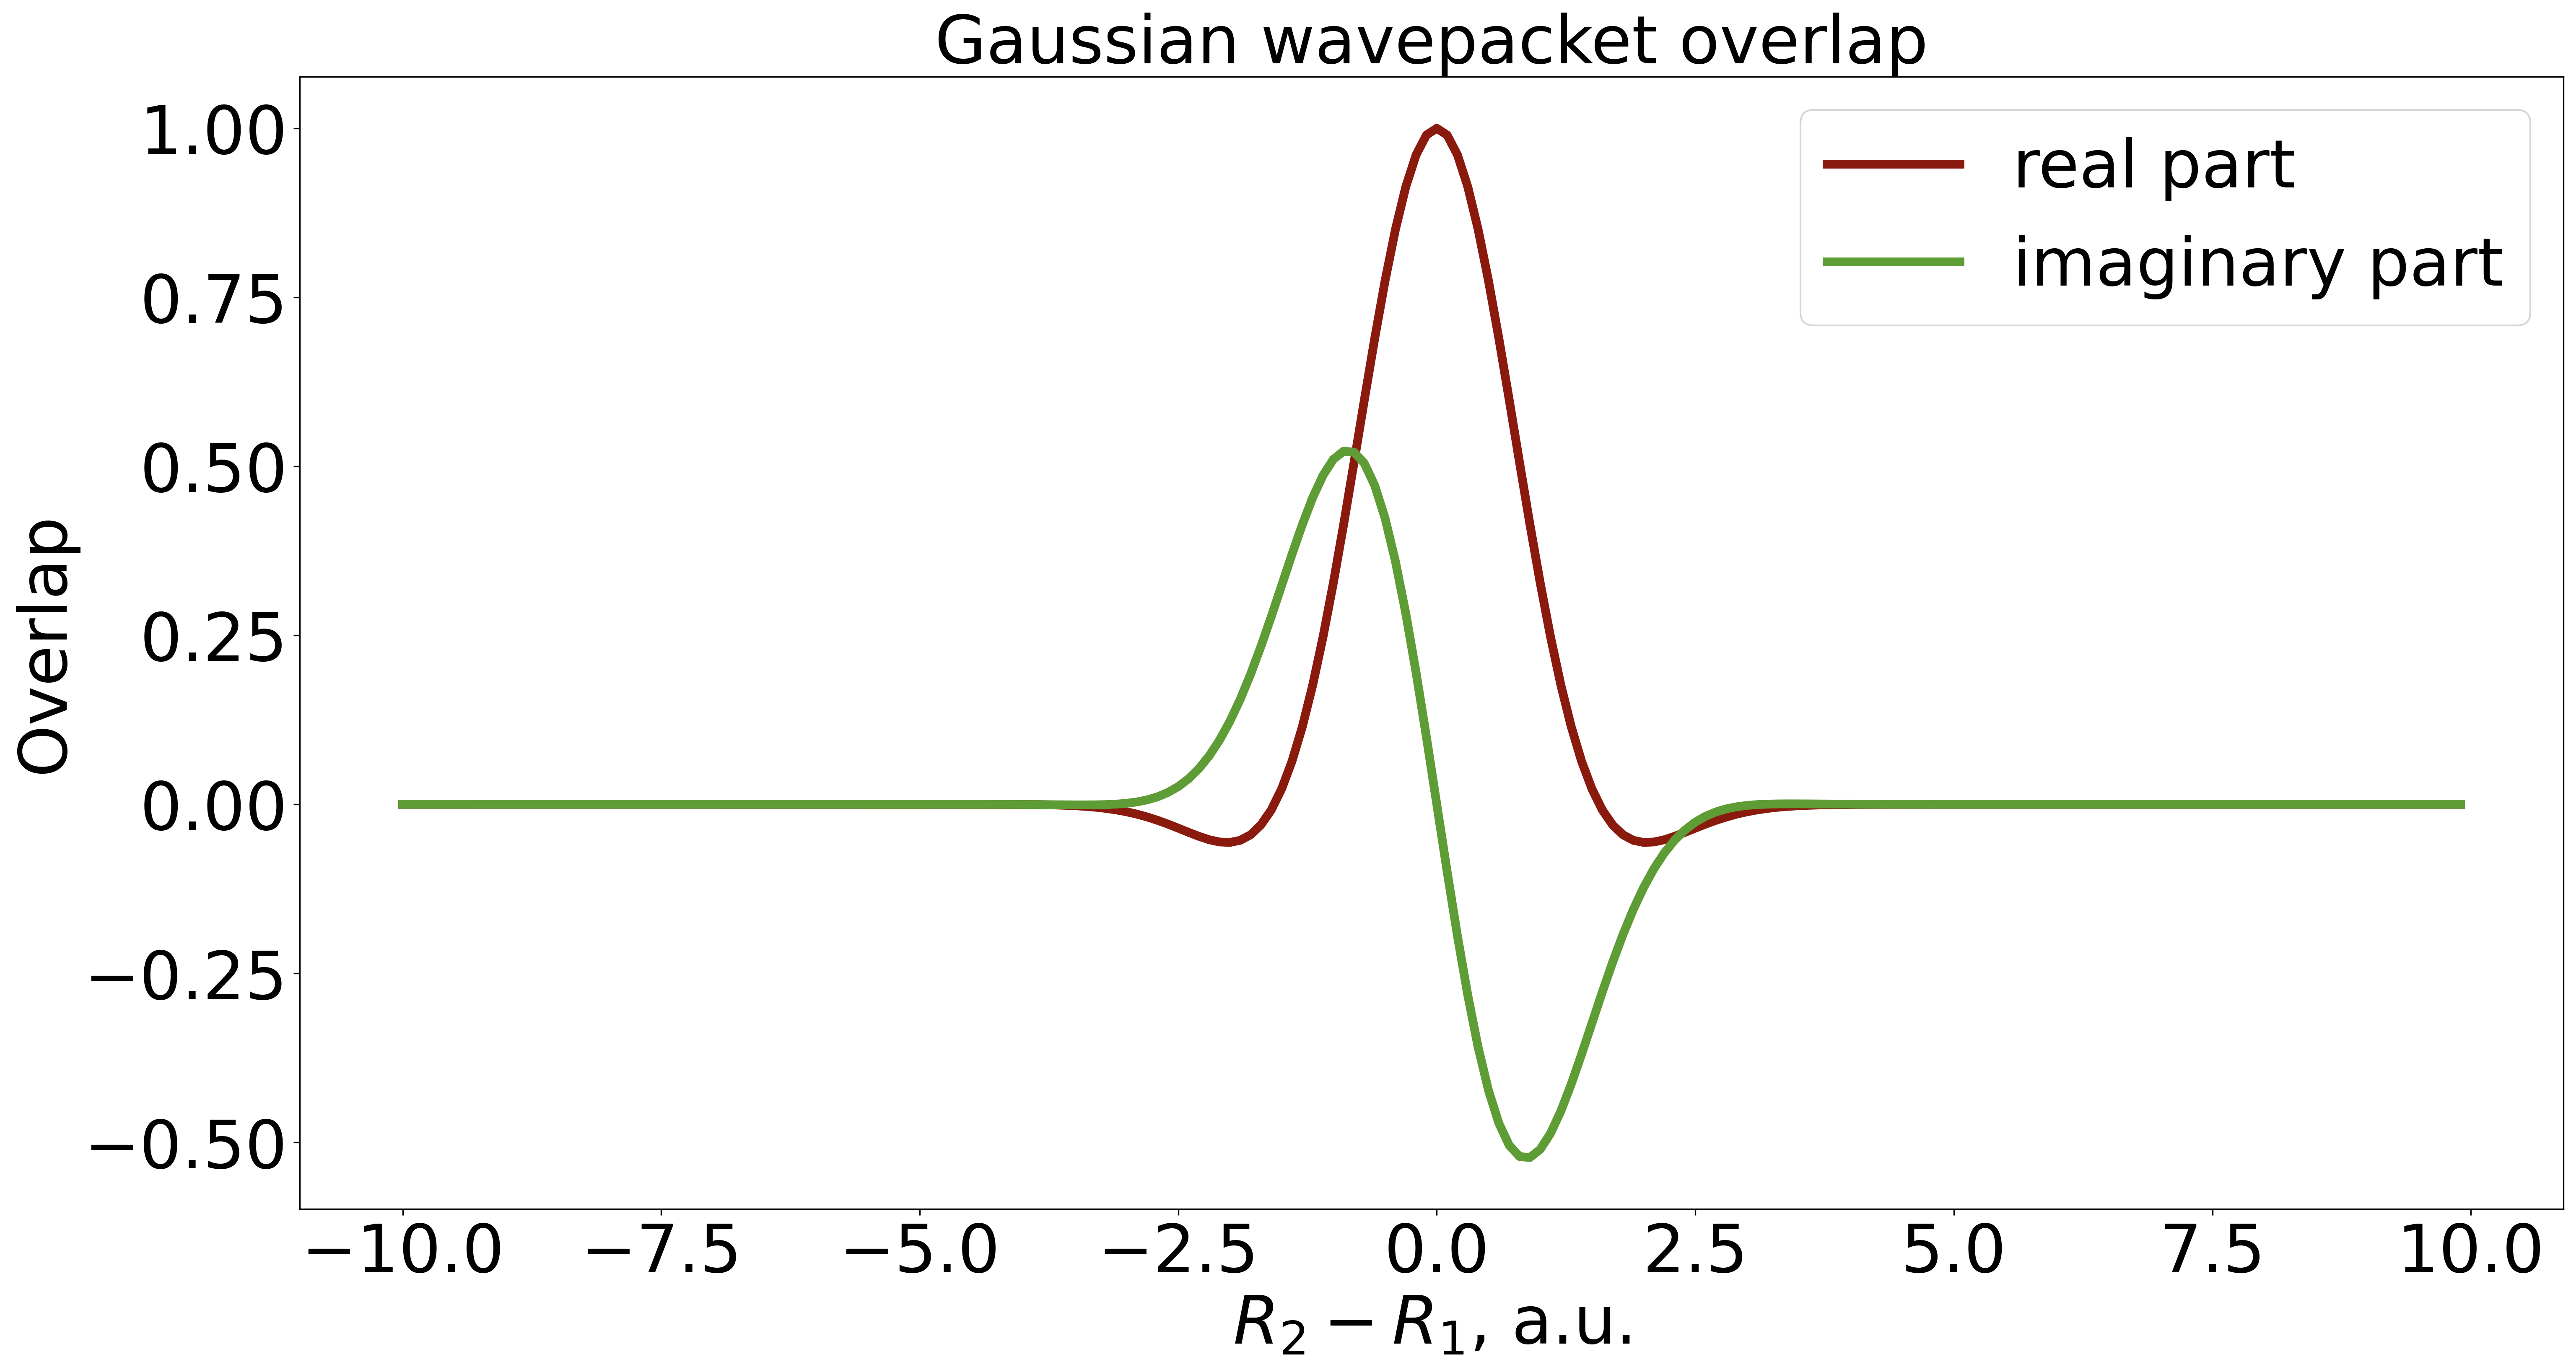

In [8]:
plt.figure(2, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Gaussian wavepacket overlap')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('Overlap')

plt.plot(x_grid, ovlp_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, ovlp_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### Exercise 2
<a name="exercise2"></a>[Back to TOC](#TOC)

Play around with the parameters of the wavepacket:
* $\alpha$ (`alp`)
* $\gamma_1$ (`gamma1`) and $\gamma_2$ (`gamma2`)
* $P_1$ (`P1`) and $P_2$ (`P2`)

How does the overlap depend on these parameters qualitatively?

### Solution 2
<a name="solution2"></a>[Back to TOC](#TOC) 
* as $\alpha$ increases, then ${\rm Im}\langle G_1|G_2\rangle$ goes to zero and ${\rm Re}\langle G_1|G_2\rangle$ starts to look like a delta function; as $\alpha$ decreases, both the real and imaginary parts look more oscillatory.
* as $\gamma_1$ increases, the area under ${\rm Im}\langle G_1|G_2\rangle$ becomes less positive; as $\gamma_2$ increases, the area under ${\rm Im}\langle G_1|G_2\rangle$ becomes more positive 


### Exercise 3
<a name="exercise3"></a>[Back to TOC](#TOC)

Note how the overlap is 1 and is real for $|R_1-R_2|=0$. Does this still hold when the parameters of the wavepackets are distinct? 

### Solution 3
<a name="solution3"></a>[Back to TOC](#TOC) 

From the derivation in the references we see that the final result for the overlap integral is 

\begin{align*}
    \langle G_1 | G_2 \rangle = \exp\left( -\dfrac{\alpha}{4}(R_1 - R_2)^2 - \dfrac{1}{4a}(P_1 - P_2)^2  \right) \cdot \exp\left( \dfrac{i}{2}(R_1 - R_2)(P_1 + P_2) \right),
\end{align*}

which can be rewritten as

\begin{align*}
    \langle G_1 | G_2 \rangle =&\exp\left( -\dfrac{\alpha}{4}(R_1 - R_2)^2 - \dfrac{1}{4a}(P_1 - P_2)^2  \right) \cdot \cos\left( \dfrac{1}{2}(R_1 - R_2)(P_1 + P_2) \right)\\
    &+ i \exp\left( -\dfrac{\alpha}{4}(R_1 - R_2)^2 - \dfrac{1}{4a}(P_1 - P_2)^2  \right) \cdot \sin\left( \dfrac{1}{2}(R_1 - R_2)(P_1 + P_2) \right),
\end{align*}
 
a sum of real and imaginary parts. Keeping in mind that $R_1 \neq R_2$, we see that the total overlap cannot be real if there is a nonzero imaginary component of $\langle G_1 | G_2 \rangle$. Thus it must be true that ${\rm Im}\langle G_1 | G_2 \rangle = 0$. A quick observation tells us this is only the case when

\begin{align*}
    \dfrac{1}{2}(R_1 - R_2)(P_1 + P_2) = n \pi,
\end{align*}
where $n \in \mathbb{Z}$. Our independent variable is $R_1 - R_2$ and thus the imaginary component of $\langle G_1 | G_2 \rangle$ is zero when 

\begin{align*}
    R_1 - R_2 = \dfrac{2n\pi}{P_1 + P_2}.
\end{align*}

Next, we find the maximum of ${\rm Re}\langle G_1 | G_2 \rangle$, given that $R_1 - R_2 = \frac{2n\pi}{P_1 + P_2}$ for some integer $n$.

### 3.2. The version with all different values, 1D

<a name="gwp_overlap-one-d-general"></a>[Back to TOC](#TOC)


This function computes the overlap:

$ < G_1 | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{1}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2 = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{1}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_overlap(double R1, double P1, double gamma1, double alpha1,
                                double R2, double P2, double gamma2, double alpha2)
       
The parameters are as follows:

  * `R1` and `R2` ( double ) - 1D coordinates of the centers of the Gaussians. 
  * `P1` and `P2` ( double ) - 1D momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alpha1` and `alpha2` (double) - the Gaussian width factors. 


  The function returns the value of the overlap of the two Gaussian functions - a complex number
  
Look for derivations [here](https://github.com/compchem-cybertraining/derivatory/tree/master/1_gaussian_wavepackets/1_matrix_elements)


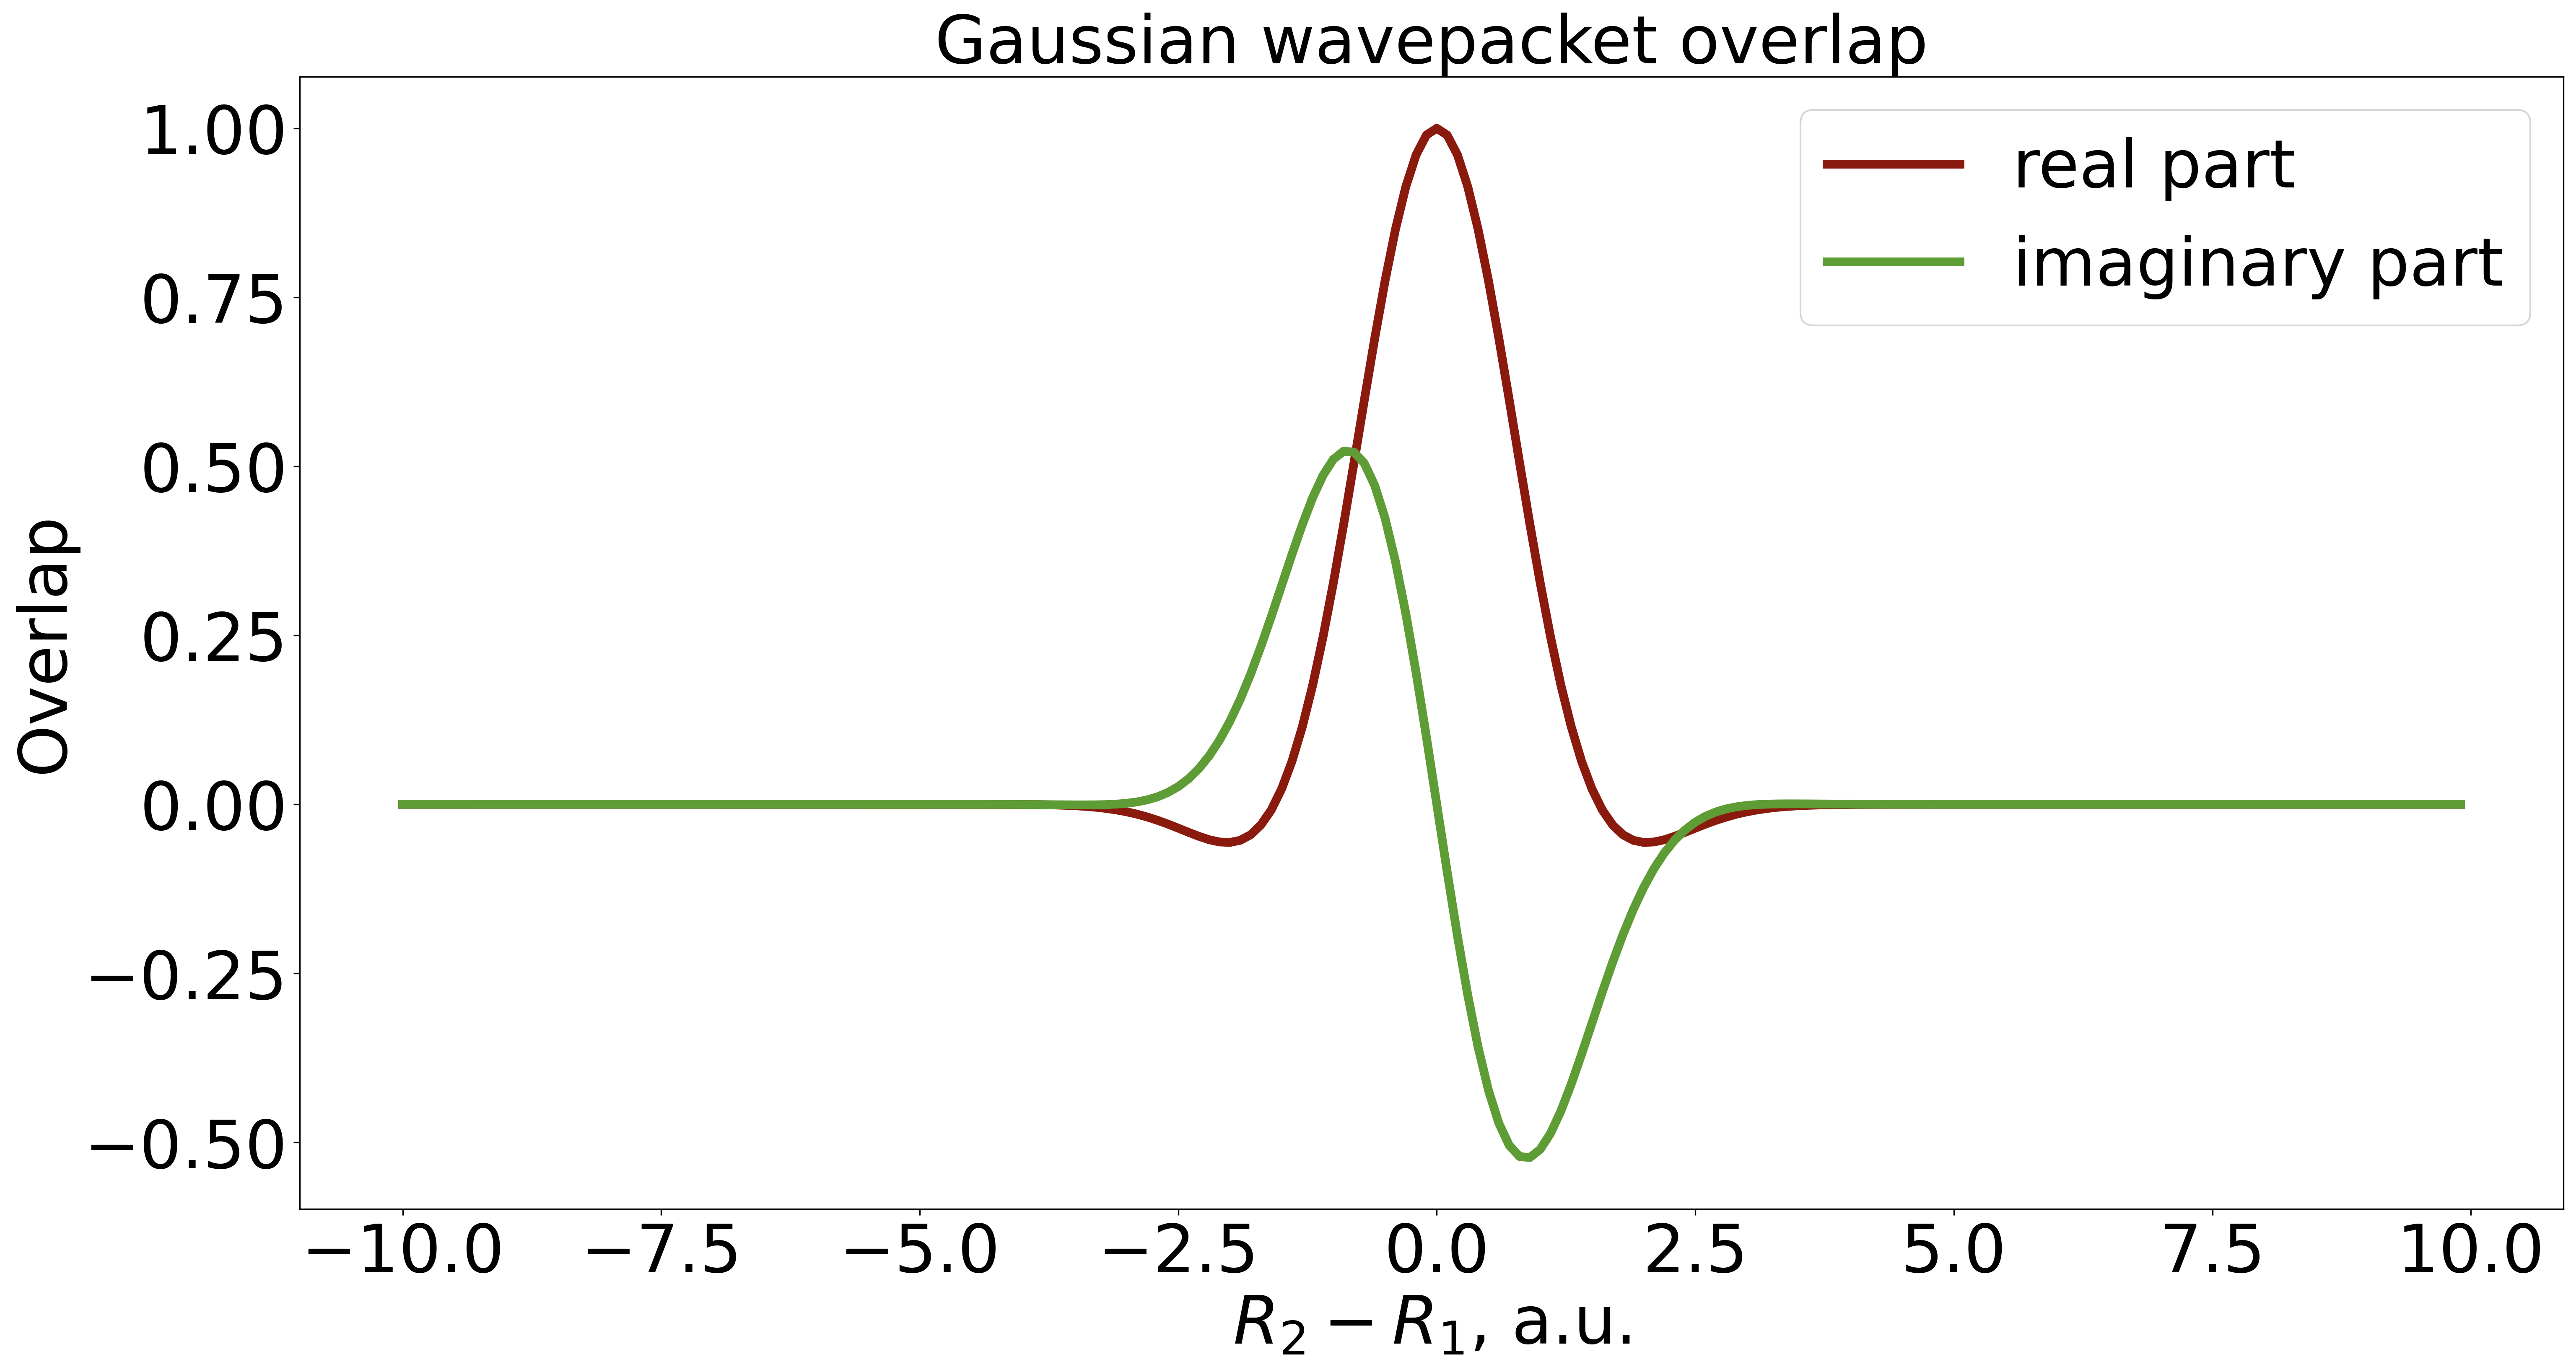

In [9]:
# parameters from section 3.1
# hbar = 1.0
# alpha = 1.0
# gamma1, gamma2 = 0.5, 0.5

R1, P1, gamma1, alpha1 = 0.0, 1.0, 0.5, 1.0
R2, P2, gamma2, alpha2 = 0.0, 1.0, 0.5, 1.0


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
ovlp_re, ovlp_im = [], []
for x in x_grid:    
    s_val = gwp_overlap(R1, P1, gamma1, alpha1, x, P2, gamma2, alpha2)
    ovlp_re.append( s_val.real )
    ovlp_im.append( s_val.imag )

    
plt.figure(2, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Gaussian wavepacket overlap')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('Overlap')

plt.plot(x_grid, ovlp_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, ovlp_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()        

Note how in this example, we can set up all the parameters to be distinct for each Gaussian

### Exercise 4
<a name="exercise4"></a>[Back to TOC](#TOC)

Change the parameters of the Gaussian wavepackets to be the same as those used in example in [section 3.1.](#gwp_overlap-same-alpha) 

Do you obtain the same results?

### Solution 4
<a name="solution4"></a>[Back to TOC](#TOC) 

Yes. I think this is supposed to be the case!


### 3.3. The version with all different values, and multi-dimensional Gaussians

<a name="gwp_overlap-many-d-general"></a>[Back to TOC](#TOC)


This function computes the overlap:

$ < G_1 | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha_1, \gamma_1) = \prod_{i=0}^{Ndof-1}  { (\frac{2 \alpha_{1,i}}{\pi})^{\frac{1}{4}} exp[-\alpha_{1,i} (r_i - R_{1,i})^2 + \frac{i P_{1,i}}{\hbar} (r_i - R_{1,i}) + \frac{i \gamma_{1,i}}{\hbar}]  }$

$G_2 = G_2(r; R_2, P_2, \alpha_2, \gamma_2) = \prod_{i=0}^{Ndof-1} { (\frac{2 \alpha_{2,i}}{\pi})^{\frac{1}{4}} exp[-\alpha_{2,i} (r_i - R_{2,i})^2 + \frac{i P_{2,i}}{\hbar} (r_i - R_{2,i}) + \frac{i \gamma_{2,i}}{\hbar}] }$

It follows the C++ signature:

    complex<double> gwp_overlap(MATRIX& R1, MATRIX& P1, MATRIX& gamma1, MATRIX& alpha1,
                                MATRIX& R2, MATRIX& P2, MATRIX& gamma2, MATRIX& alpha2)
       
The parameters are as follows:

  * `R1` and `R2` ( MATRIX(Ndof, 1) ) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` ( MATRIX(Ndof, 1) ) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` ( MATRIX(Ndof, 1) ) - multidimensional phases of the overall Gaussians
  * `alpha1` and `alpha2` ( MATRIX(Ndof, 1) ) - multidimensional Gaussian width factor. 

  The function returns the value of the overlap of the two Gaussian functions - a complex number
  
Look for derivations [here](https://github.com/compchem-cybertraining/derivatory/tree/master/1_gaussian_wavepackets/1_matrix_elements)


No handles with labels found to put in legend.


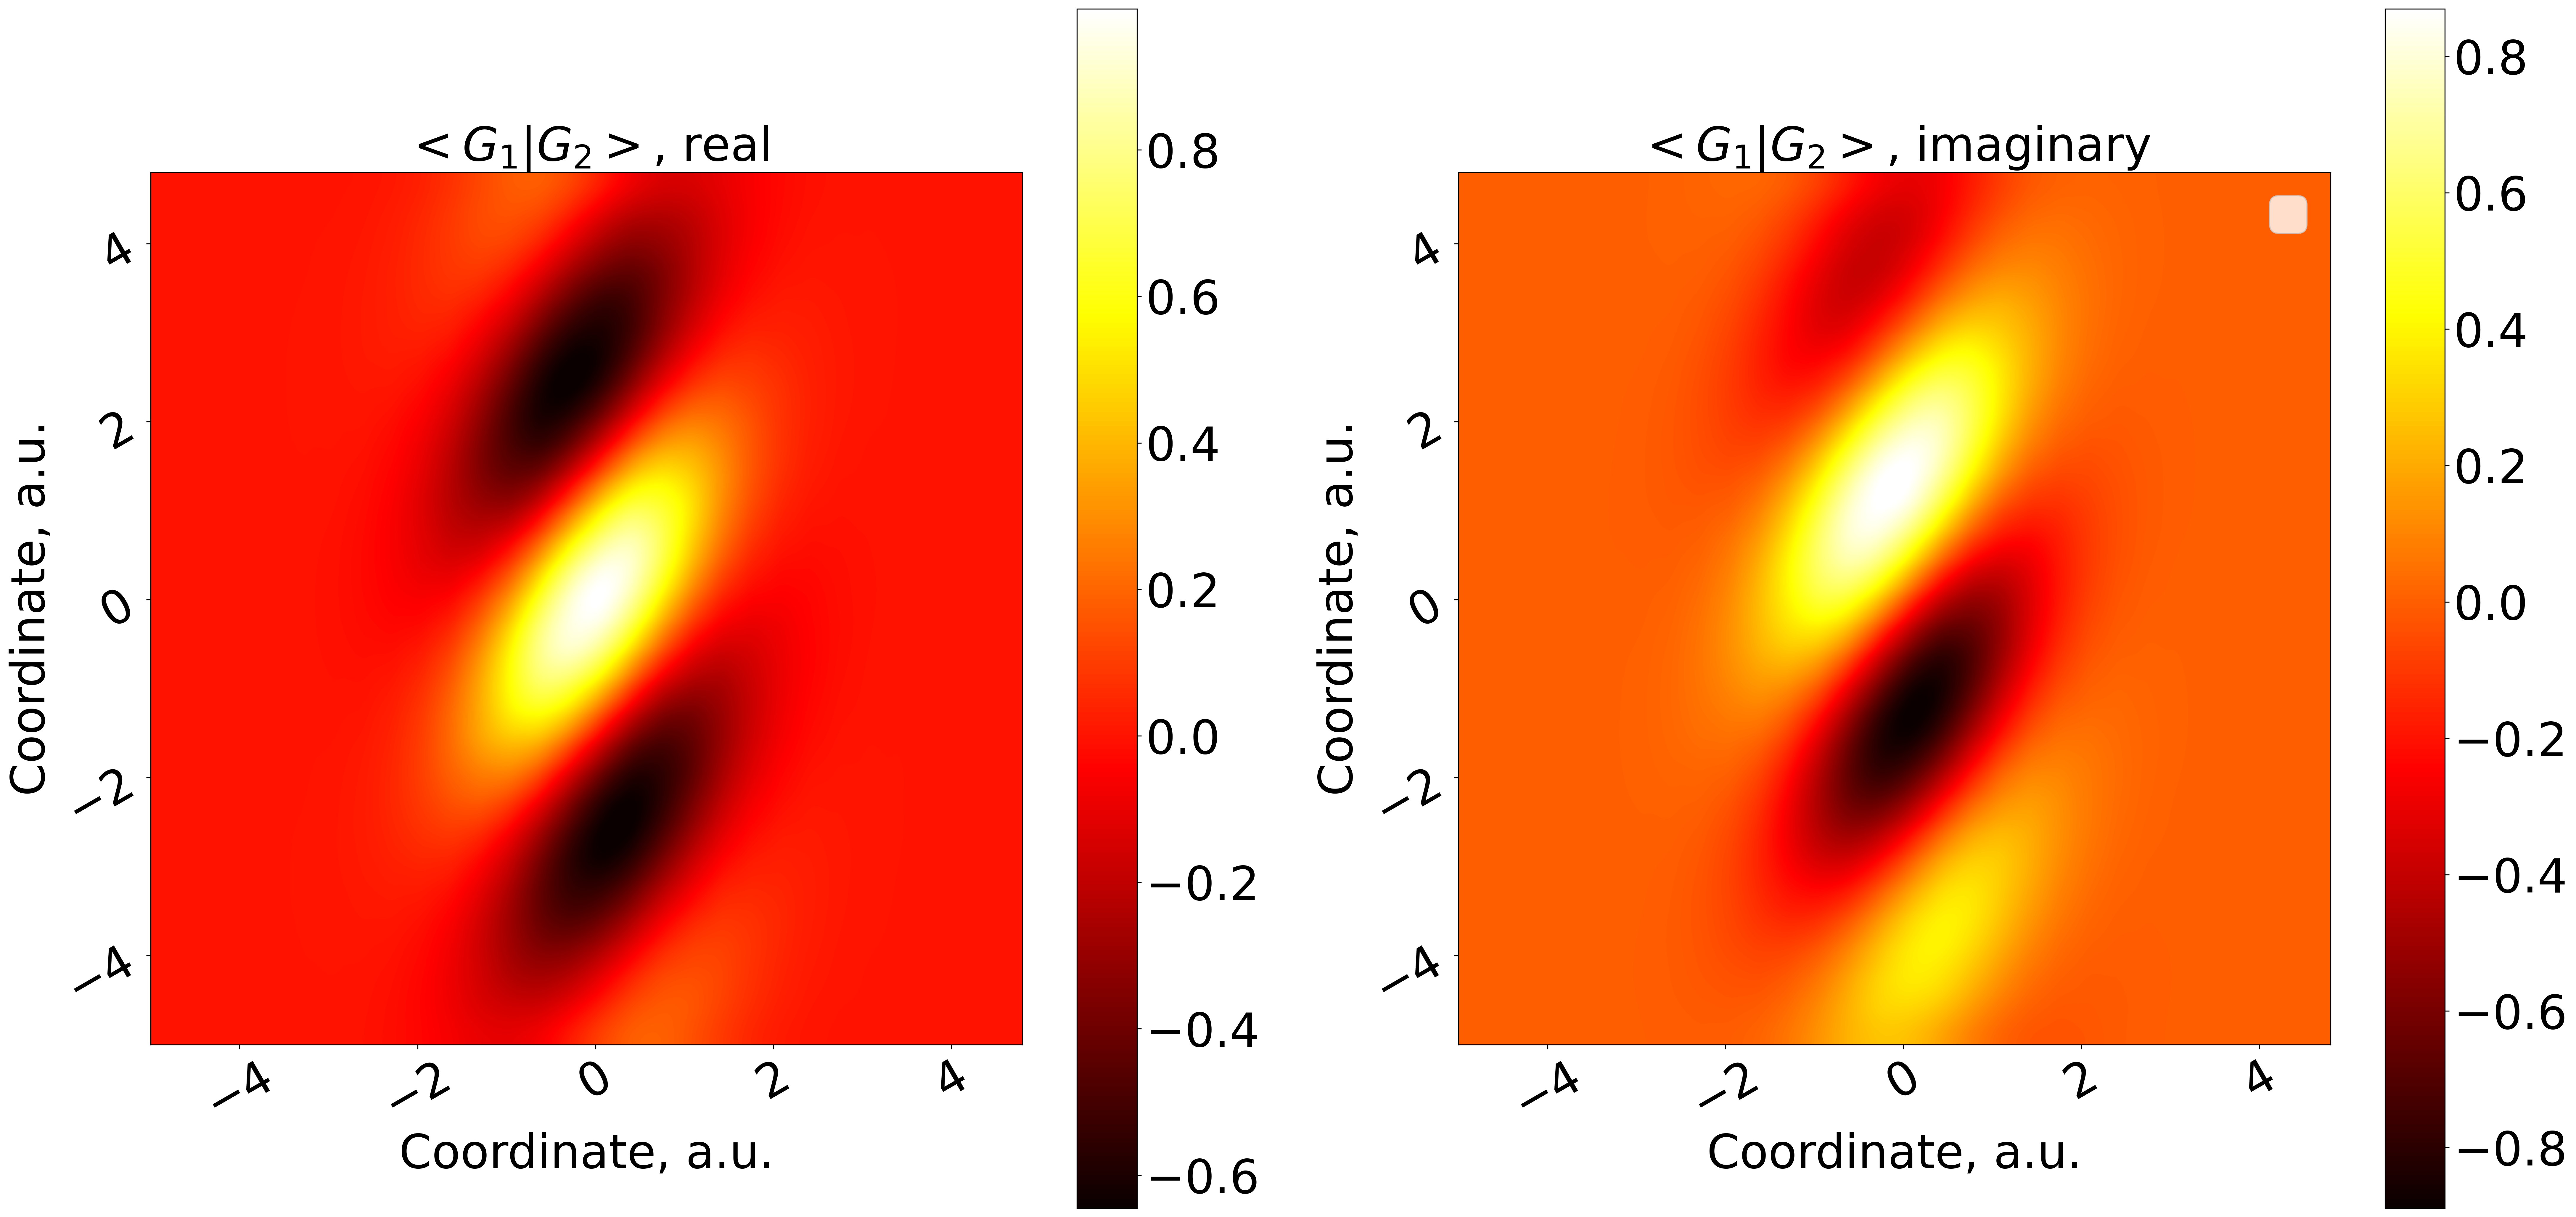

In [21]:
R1 = MATRIX(2,1); R1.set(0,0, 0.0); R1.set(1,0, 0.0)
P1 = MATRIX(2,1); P1.set(0,0, 1.0); P1.set(1,0, -1.0)
gamma1 = MATRIX(2,1); gamma1.set(0, 0, 0.0);  gamma1.set(1, 0, 0.0);
alpha1 = MATRIX(2,1); alpha1.set(0, 0, 1.0);  alpha1.set(1, 0, 0.1);

R2 = MATRIX(2,1); R2.set(0,0, 0.0); R2.set(1,0, 0.0)
P2 = MATRIX(2,1); P2.set(0,0, 1.0); P2.set(1,0, -1.0)
gamma2 = MATRIX(2,1); gamma2.set(0, 0, 0.0);  gamma2.set(1, 0, 0.0);
alpha2 = MATRIX(2,1); alpha2.set(0, 0, 1.0);  alpha2.set(1, 0, 0.1);


# =========== Compute the results on a 2D grid =============

x_grid, y_grid = [], []
for i in range(50):
    x_grid.append(-5.0 + 0.2*i)
    y_grid.append(-5.0 + 0.2*i)
    
g_re, g_im = [], []
for x in x_grid:
    g_re_x, g_im_x = [], []
    for y in y_grid:
        
        R2.set(0, 0, x)
        R2.set(1, 0, y)
    
        g_val = gwp_overlap(R1, P1, gamma1, alpha1, R2, P2, gamma2, alpha2)
        g_re_x.append( g_val.real )
        g_im_x.append( g_val.imag )
        
    g_re.append(g_re_x)
    g_im.append(g_im_x)  
    
    
# =========== Plot =============    

plt.figure(1, figsize=(36, 18), dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('$< G_1 | G_2 >$, real')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_re, "hot", 30j )

plt.subplot(1,2,2)
plt.title('$< G_1 | G_2 >$, imaginary')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_im, "hot", 30j )

plt.legend()
plt.show()
plt.close()

### Exercise 5
<a name="exercise5"></a>[Back to TOC](#TOC)

Set up the calculation of the overlap of the two Gaussian wavepackets in 3 dimensions as a function of the separation of between centers of the 2 wavepackets

### Solution 5
<a name="solution5"></a>[Back to TOC](#TOC) 



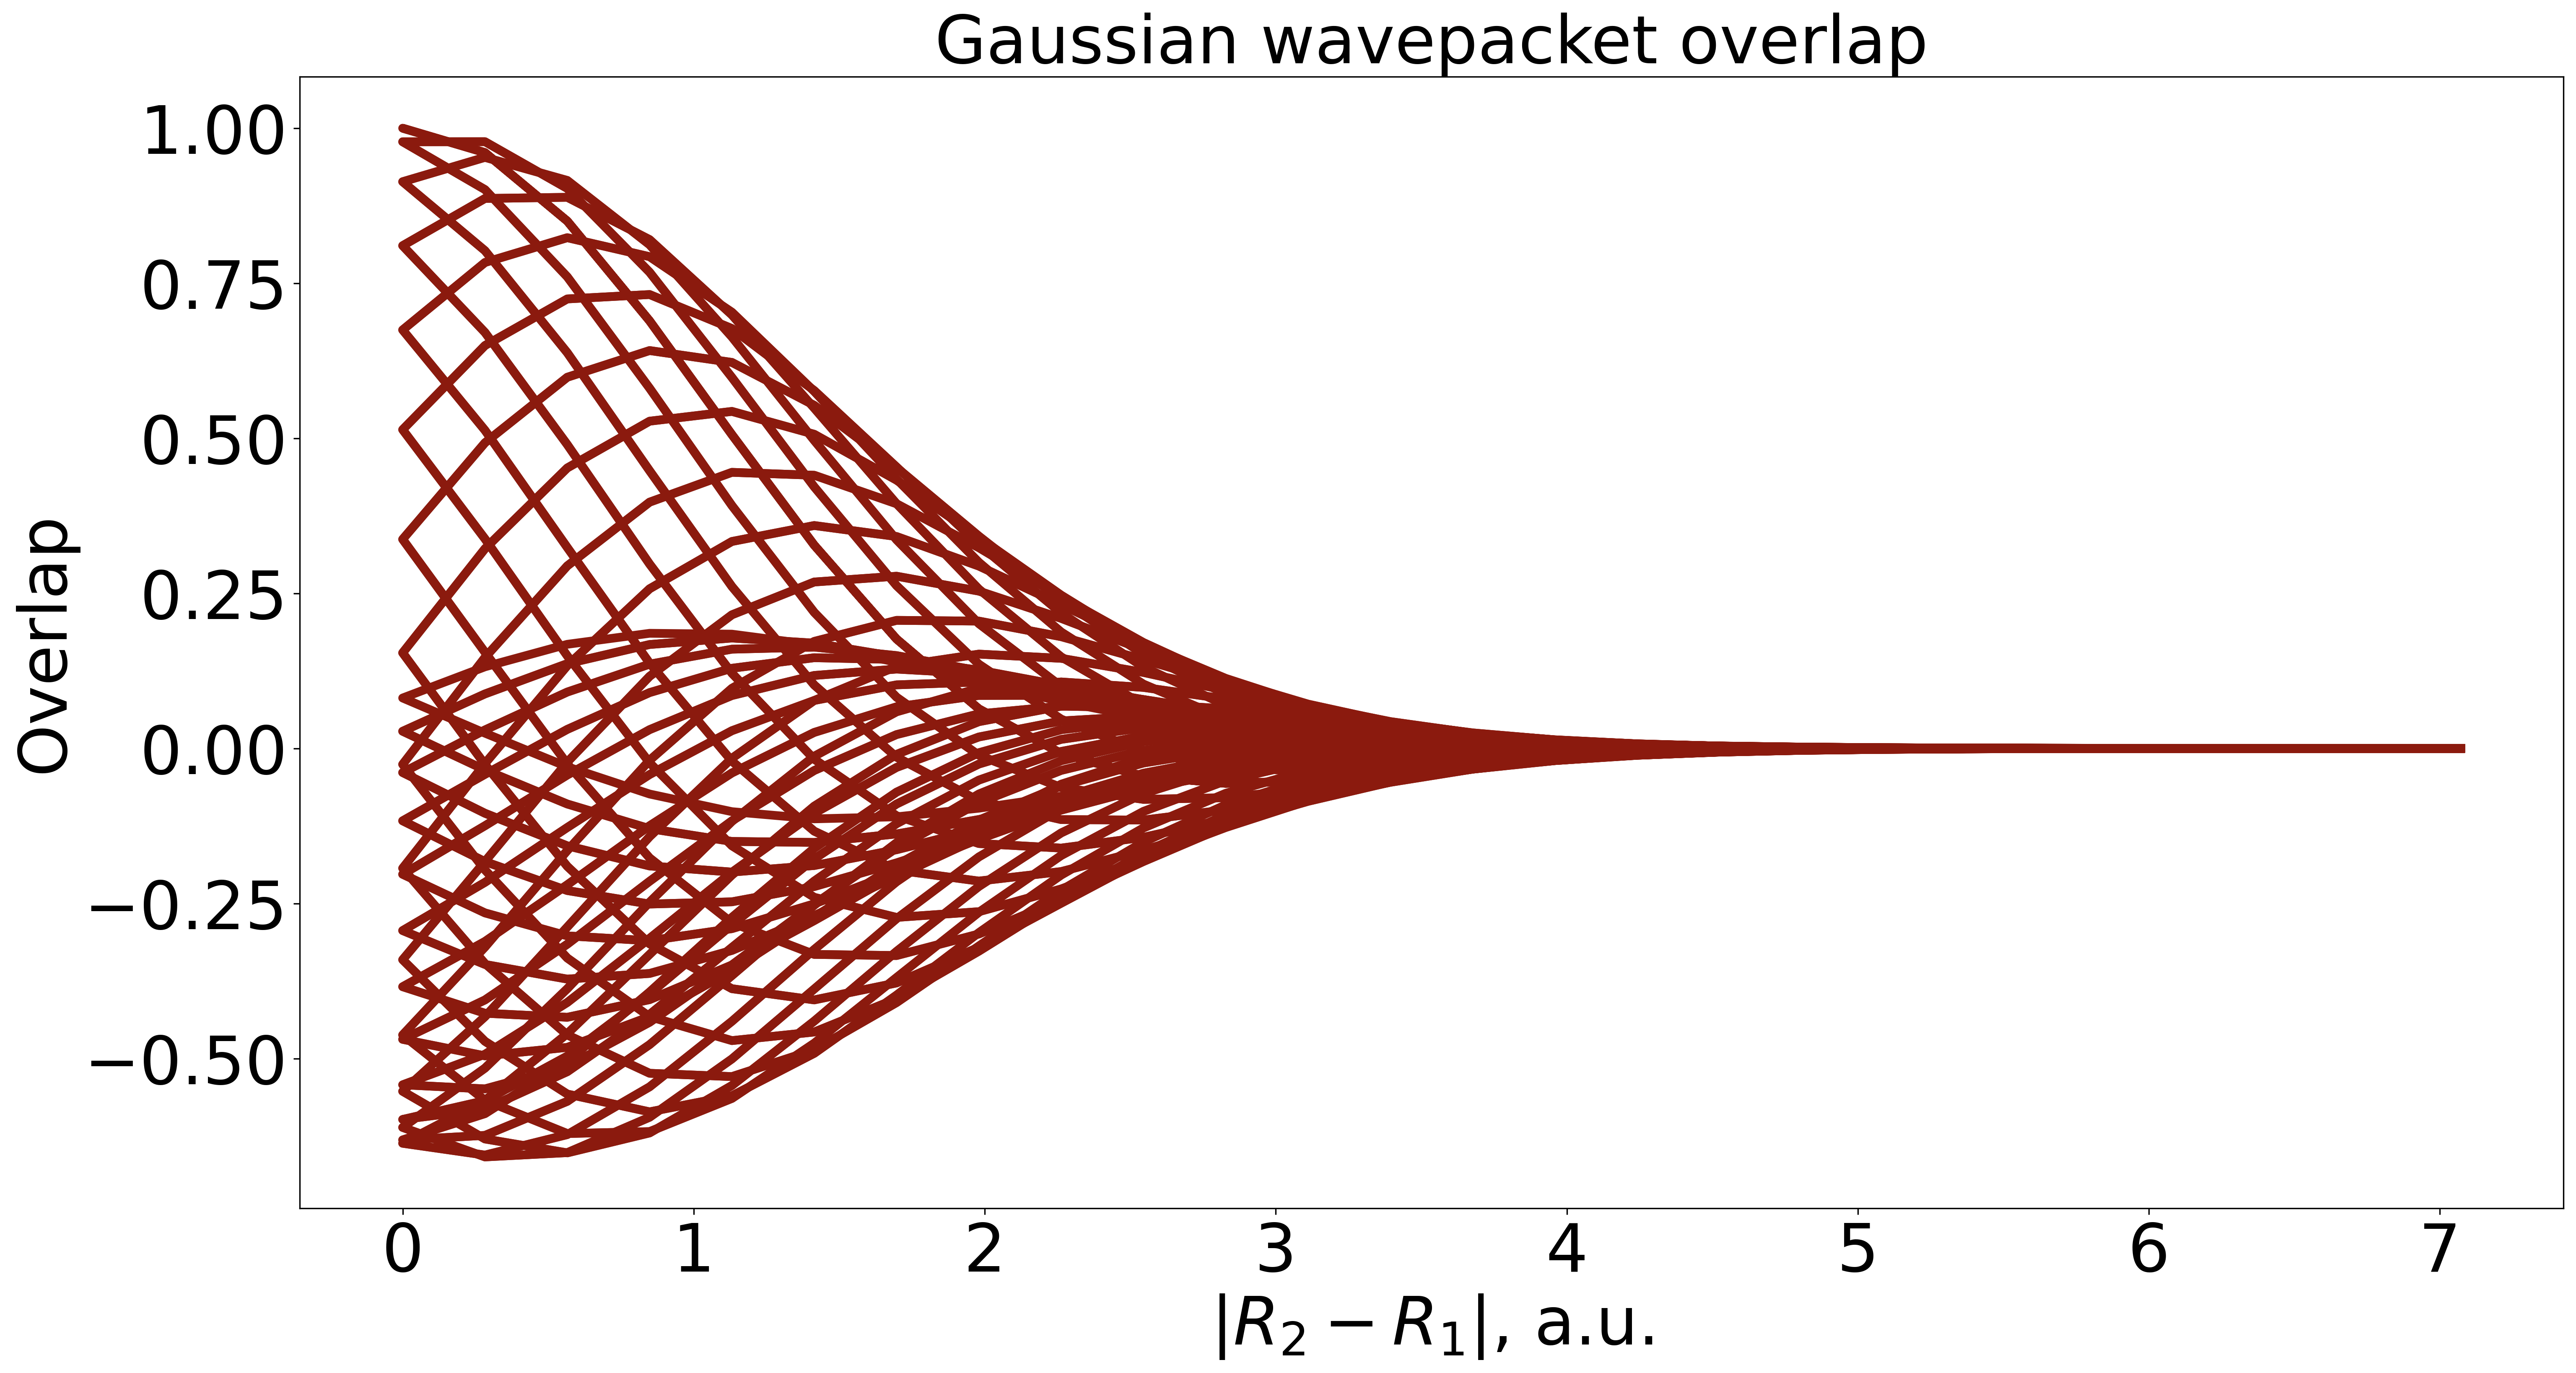

In [32]:
# =========== Plots the real and imaginary components of the overlap integral =============

norm_grid = []
ctr = 0
while(ctr < len(x_grid)):
    temp = x_grid[ctr]**2 + y_grid[ctr]**2
    norm_grid.append(temp**0.5)
    #temp = x_grid[ctr] 
    #norm_grid.append(temp)
    ctr = ctr + 1
    
# =========== Plot =============  
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
#plt.subplot(1,1,1)
plt.title('Gaussian wavepacket overlap')
plt.xlabel('$|R_2-R_1|$, a.u.')
plt.ylabel('Overlap')

plt.plot(norm_grid, g_re , label='real part', linewidth=5, color = colors["11"]) 
#plt.plot(norm_grid, g_im , label='imaginary part', linewidth=5, color = colors["21"]) 

#plt.legend()
plt.show()
plt.close()  
          

### Exercise 6
<a name="exercise6"></a>[Back to TOC](#TOC)

Write a script to compute the overlap of N-dimensional Gaussian wavepackets as a function of the dimensionality, N.

Assume that the corresponding parameters for each dimension are the same, e.g. $\gamma_0 = \gamma_1 = ... \gamma_{N-1}$. Take the parameters used in example in [section 3.1.](#gwp_overlap-same-alpha) 

Hint: one solution is pretty trivial, but please use the one where you'd set up all the N-dimensional GWPs explicitly.

### Solution 6
<a name="solution6"></a>[Back to TOC](#TOC) 

a

## 4. Computing transition dipole moment with `gwp_dipole` function
<a name="gwp_dipole"></a>[Back to TOC](#TOC)


### 4.1. The version with same alpha

<a name="gwp_dipole-same-alpha"></a>[Back to TOC](#TOC)

This function computes the transition dipole moment matrix elements, for each DOF of the vector $r$:

$ < G_1 | r | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    CMATRIX gwp_dipole(MATRIX& R1, MATRIX& P1, double gamma1, 
                       MATRIX& R2, MATRIX& P2, double gamma2, 
                       double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the transition dipole moment matrix elements with the two Gaussian functions - a list of complex numbers - one per each DOF. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | r | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a vector, whose dimensionality is equal to the dimensionality of the problem. In this case, the dimensionality is 1, so we only extract the $< G_1 | x | G_2 >$ components.

<a name="gwp_dipole_function"></a>

In [ ]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
mu_re, mu_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    mu_val = gwp_dipole(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar).get(0,0)
    mu_re.append( mu_val.real )
    mu_im.append( mu_val.imag )


Now plot it:

In [ ]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Transition dipole matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | r | G_2 >$')

plt.plot(x_grid, mu_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, mu_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### 4.2. The version with all different values, 1D

<a name="gwp_dipole-one-d-general"></a>[Back to TOC](#TOC)

This function computes the transition dipole moment matrix elements:

$ < G_1 | r | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{1}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2 = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{1}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

     complex<double> gwp_dipole(double R1, double P1, double gamma1, double alpha1,
                                double R2, double P2, double gamma2, double alpha2)
       
The parameters are as follows:

  * `R1` and `R2` ( double ) - 1D coordinates of the centers of the Gaussians. 
  * `P1` and `P2` ( double ) - 1D momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alpha1` and `alpha2` (double) - the Gaussian width factors. 


  The function returns the value of the transition dipole moment matrix element with two Gaussian functions - a complex number
  
Look for derivations [here](https://github.com/compchem-cybertraining/derivatory/tree/master/1_gaussian_wavepackets/1_matrix_elements)


### Exercise 7
<a name="exercise7"></a>[Back to TOC](#TOC)

* Set up the calculation of the 1D transition dipole matrix elements for two Gaussian wavepackets with the parameters  used in [section 4.1](#gwp_dipole-same-alpha). Make sure you reproduce those results.

* Now, vary the $\gamma$ and $\alpha$ parameters to have distinct values for each GWP. How do the computed plots change?

### 4.3. The version with all different values, and multi-dimensional Gaussians

<a name="gwp_dipole-many-d-general"></a>[Back to TOC](#TOC)


This function computes the transition dipole moment matrix elements:

$ < G_1 | r | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha_1, \gamma_1) = \prod_{i=0}^{Ndof-1}  { (\frac{2 \alpha_{1,i}}{\pi})^{\frac{1}{4}} exp[-\alpha_{1,i} (r_i - R_{1,i})^2 + \frac{i P_{1,i}}{\hbar} (r_i - R_{1,i}) + \frac{i \gamma_{1,i}}{\hbar}]  }$

$G_2 = G_2(r; R_2, P_2, \alpha_2, \gamma_2) = \prod_{i=0}^{Ndof-1} { (\frac{2 \alpha_{2,i}}{\pi})^{\frac{1}{4}} exp[-\alpha_{2,i} (r_i - R_{2,i})^2 + \frac{i P_{2,i}}{\hbar} (r_i - R_{2,i}) + \frac{i \gamma_{2,i}}{\hbar}] }$

It follows the C++ signature:

    CMATRIX gwp_dipole(MATRIX& R1, MATRIX& P1, MATRIX& gamma1, MATRIX& alpha1,
                       MATRIX& R2, MATRIX& P2, MATRIX& gamma2, MATRIX& alpha2)
       
The parameters are as follows:

  * `R1` and `R2` ( MATRIX(Ndof, 1) ) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` ( MATRIX(Ndof, 1) ) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` ( MATRIX(Ndof, 1) ) - multidimensional phases of the overall Gaussians
  * `alpha1` and `alpha2` ( MATRIX(Ndof, 1) ) - multidimensional Gaussian width factor. 
  
**NOTE**: Unlike a 1D version of the `gwp_dipole` function or the multi-dimensional version of the `gwp_overlap`, this function returns a complex matrix (CMATRIX) object - this is a vector containing the transition dipole moment elements for each DOF

Look for derivations [here](https://github.com/compchem-cybertraining/derivatory/tree/master/1_gaussian_wavepackets/1_matrix_elements)


As a demonstration, we'll consider matrix elements in 2 dimensions. 

We will compute both the $< G_1 | x | G_2 >$ and $< G_1 | y | G_2 >$ integrals, each of which would have a real and imaginary part.

It is convenient to adapt the above snippets for computing and plotting the overals of 2D GWPs:

In [ ]:
R1 = MATRIX(2,1); R1.set(0,0, 0.0); R1.set(1,0, 0.0)
P1 = MATRIX(2,1); P1.set(0,0, 1.0); P1.set(1,0, -1.0)
gamma1 = MATRIX(2,1); gamma1.set(0, 0, 0.0);  gamma1.set(1, 0, 0.0);
alpha1 = MATRIX(2,1); alpha1.set(0, 0, 1.0);  alpha1.set(1, 0, 0.1);

R2 = MATRIX(2,1); R2.set(0,0, 0.0); R2.set(1,0, 0.0)
P2 = MATRIX(2,1); P2.set(0,0, 1.0); P2.set(1,0, -1.0)
gamma2 = MATRIX(2,1); gamma2.set(0, 0, 0.0);  gamma2.set(1, 0, 0.0);
alpha2 = MATRIX(2,1); alpha2.set(0, 0, 1.0);  alpha2.set(1, 0, 0.1);


# =========== Compute the results on a 2D grid =============

x_grid, y_grid = [], []
for i in range(50):
    x_grid.append(-5.0 + 0.2*i)
    y_grid.append(-5.0 + 0.2*i)
    
mu_x_re, mu_x_im = [], []
mu_y_re, mu_y_im = [], []
for x in x_grid:
    mu_x_re_x, mu_x_im_x = [], []
    mu_y_re_x, mu_y_im_x = [], []
    for y in y_grid:
        
        R2.set(0, 0, x)
        R2.set(1, 0, y)
    
        mu_val = gwp_dipole(R1, P1, gamma1, alpha1, R2, P2, gamma2, alpha2)
        mu_x_re_x.append( mu_val.get(0,0).real )
        mu_x_im_x.append( mu_val.get(0,0).imag )
        
        mu_y_re_x.append( mu_val.get(1,0).real )
        mu_y_im_x.append( mu_val.get(1,0).imag )
        
    mu_x_re.append(mu_x_re_x)
    mu_x_im.append(mu_x_im_x)  
    
    mu_y_re.append(mu_y_re_x)
    mu_y_im.append(mu_y_im_x)  

    
    
# =========== Plot =============    

plt.figure(1, figsize=(36, 36), dpi=300, frameon=False)
plt.subplot(2,2,1)
plt.title('$< G_1 | x | G_2 >$, real')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, mu_x_re, "hot", 30j )

plt.subplot(2,2,2)
plt.title('$< G_1 | x | G_2 >$, imaginary')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, mu_x_im, "hot", 30j )

plt.subplot(2,2,3)
plt.title('$< G_1 | y | G_2 >$, real')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, mu_y_re, "hot", 30j )

plt.subplot(2,2,4)
plt.title('$< G_1 | y | G_2 >$, imaginary')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, mu_y_im, "hot", 30j )


plt.legend()
plt.show()
plt.close()

## 5. Computing derivative coupling matrix elements with `gwp_coupling` function
<a name="gwp_coupling"></a>[Back to TOC](#TOC)


### 5.1. The version with same alpha

<a name="gwp_coupling-same-alpha"></a>[Back to TOC](#TOC)


This function computes the derivative coupling matrix elements, for each DOF of the vector $r$:

$ < G_1 | \nabla_r | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    CMATRIX gwp_coupling(MATRIX& R1, MATRIX& P1, double gamma1, 
                         MATRIX& R2, MATRIX& P2, double gamma2, 
                         double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the derivative coupling matrix elements with the two Gaussian functions - a list of complex numbers - one per each DOF. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | \nabla_r | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a vector, whose dimensionality is equal to the dimensionality of the problem. In this case, the dimensionality is 1, so we only extract the $< G_1 | \frac{d}{dx} | G_2 >$ components.

<a name="gwp_coupling_function"></a>

In [ ]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
dc_re, dc_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    dc_val = gwp_coupling(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar).get(0,0)
    dc_re.append( dc_val.real )
    dc_im.append( dc_val.imag )


Now, plot it:

In [ ]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Derivative coupling matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | d/dx | G_2 > $')

plt.plot(x_grid, dc_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, dc_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### 5.2. The general versions - with all different values, 1D and multi-dimensional

<a name="gwp_coupling-general"></a>[Back to TOC](#TOC)

It follows the C++ signature similar to those of `gwp_dipole` discussed above, namely:

     complex<double> gwp_coupling(double R1, double P1, double gamma1, double alpha1,
                                  double R2, double P2, double gamma2, double alpha2)
                               
and

    CMATRIX gwp_coupling(MATRIX& R1, MATRIX& P1, MATRIX& gamma1, MATRIX& alpha1,
                         MATRIX& R2, MATRIX& P2, MATRIX& gamma2, MATRIX& alpha2)
       

### Exercise 8
<a name="exercise8"></a>[Back to TOC](#TOC)

* Set up the calculation of the 1D derivative coupling dipole matrix elements for two Gaussian wavepackets with the parameters used in [section 5.1](#gwp_coupling-same-alpha). Make sure you reproduce those results.

* Now, vary the $\gamma$ and $\alpha$ parameters to have distinct values for each GWP. How do the computed plots change?

### Exercise 9
<a name="exercise9"></a>[Back to TOC](#TOC)

* Using the example of computing transition dipole matrix elements in 2D, as discussed [above](#gwp_dipole-many-d-general), perform the analogous calculations and plotting for the 2D derivative coupling matrix elements.

## 6. Computing the kinetic energy matrix elements with `gwp_kinetic` function
<a name="gwp_kinetic"></a>[Back to TOC](#TOC)


### 6.1. The version with same alpha

<a name="gwp_kinetic-same-alpha"></a>[Back to TOC](#TOC)

This function computes the kinetic energy matrix elements (up to a constant):

$ < G_1 | \nabla_r^2 | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_kinetic(MATRIX& R1, MATRIX& P1, double gamma1, 
                                MATRIX& R2, MATRIX& P2, double gamma2, 
                                double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the kinetic operator (up to a constant prefactor) matrix elements with two Gaussian functions - a complex number, which includes the summation over all DOFs. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | \nabla_r^2 | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a scalar - the summation over all DOFs has been made by the function.

<a name="gwp_kinetic_function"></a>

In [ ]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
kin_re, kin_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    kin_val = gwp_kinetic(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar)
    kin_re.append( kin_val.real )
    kin_im.append( kin_val.imag )

Now lets plot it:

In [ ]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Kinetic energy matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | d^2/dx^2 | G_2 > $')

plt.plot(x_grid, kin_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, kin_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

Lets compare the classical kinetic energy and the quantum one.

We consider just a single Gaussian WP, $G = G(r; R, P, \alpha, \gamma)$. 

Its parameter $P$ plays a role of classical momentum, so assuming the particle has a mass of $m = 1$, we can see that the kinetic energy should be:

$ E_{kin}^{class} = \frac{P^2}{2 m}$

The corresponding quantum value would be:

$ E_{kin}^{quant} = -\frac{\hbar^2}{2 m} < G | \frac{d^2}{dx^2} | G > $

Lets compare what we obtain:

In [ ]:
hbar = 1.0
alpha = 0.001
gamma = 0.1
mass = 1.0
p = 1.0

print(F"Kinetic energy, classical = {p**2/(2.0*mass)}")

P = MATRIX(1,1); P.set(0, 0, p)
R = MATRIX(1,1); R.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, p)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)

kin_val = gwp_kinetic(R, P, gamma, R2, P2, gamma, alpha, hbar)
print(F"Kinetic energy, quantum = { -hbar**2 * kin_val/(2.0*mass) }")

Lets compute the kinetic energy for several other values of the parameter $\alpha$

In [ ]:
for alpha in [0.01, 0.1, 1.0, 10.0]:
    kin_val = gwp_kinetic(R, P, gamma, R2, P2, gamma, alpha, hbar)
    print(F"alpha={alpha} Kinetic energy, quantum = { -hbar**2 * kin_val/(2.0*mass) }")

#### Some useful observations

* Note how the quantum kinetic energy approaches the classical kinetic energy as $\alpha ->0 $

* Note how the kinetic energy increases as $\alpha$ increases - this is zero point energy, ZPE - essentially, more and more squizing the wavepacket into a delta-function, means small $\Delta x$ and therefore (according to the uncertainty principle) large $\Delta p_x$, which in turn means large average kinetic energy

* So, thinking of classical particles as a limiting case of Gaussian wavepackets with zero width (delta-functions) is inconsistent with the uncertainty principle. 

### 6.2. The general versions - with all different values, 1D and multi-dimensional

<a name="gwp_kinetic-general"></a>[Back to TOC](#TOC)

It follows the C++ signature similar to those of `gwp_overlap` discussed above, namely:

     complex<double> gwp_kinetic(double R1, double P1, double gamma1, double alpha1,
                                 double R2, double P2, double gamma2, double alpha2)
                               
and

    complex<double> gwp_kinetic(MATRIX& R1, MATRIX& P1, MATRIX& gamma1, MATRIX& alpha1,
                                MATRIX& R2, MATRIX& P2, MATRIX& gamma2, MATRIX& alpha2)
       

### Exercise 10
<a name="exercise10"></a>[Back to TOC](#TOC)

* Do the exercises [4](#exercise4), [5](#exercise5), and [6](#exercise6), but use the `gwp_kinetic` function instead of the `gwp_overlap`